In [110]:
import json
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np


data_folder = "../data"

names = [x for x in os.listdir(data_folder) if not x.endswith("zip")]
discrepancy_data  = []
for name in names:
    
    path = os.path.join(data_folder, name)
    functions = [x for x in os.listdir(path) if x.endswith("json")]
    for filename in functions:
        filepath = os.path.join(path, filename)
        
        with open(filepath) as f:
            text = f.read()
            data = json.loads(text.replace(": inf", ": 0"))
        
        for scen in data['scenarios']:
            *x, cache = data['algorithm']['name'].split("-")
            for run_id, run in enumerate(scen['runs'], 1):
                discrepancy_data.append((
                    data['function_id'], 
                    data['algorithm']['name'],
                    scen['dimension'],
                    run_id, 
                    run['instance'],
                    run['cache_discrepancy'],
                    run['best']['evals'],
                    run['best']['y'],
                    int(cache) if cache.isdigit() else 0
                ))

data = pd.DataFrame(discrepancy_data, 
                    columns=["fid", "alg", "dimension",  
                             "run", "instance", "discrepancy", "evals", "y", "cache_size"])
view = data.query(
    "discrepancy > 0 and not alg.str.contains('mirror') and not alg.str.contains('orthogonal')"
).groupby(["dimension", "alg"])['discrepancy'].mean().unstack().T.sort_index()
view['cache_size'] = view.index.str.rsplit("-").str[-1].astype(int)
view.index = view.index.str.split("-", n=2).str[-1]
view.index = view.index.str.replace("-cache", "")

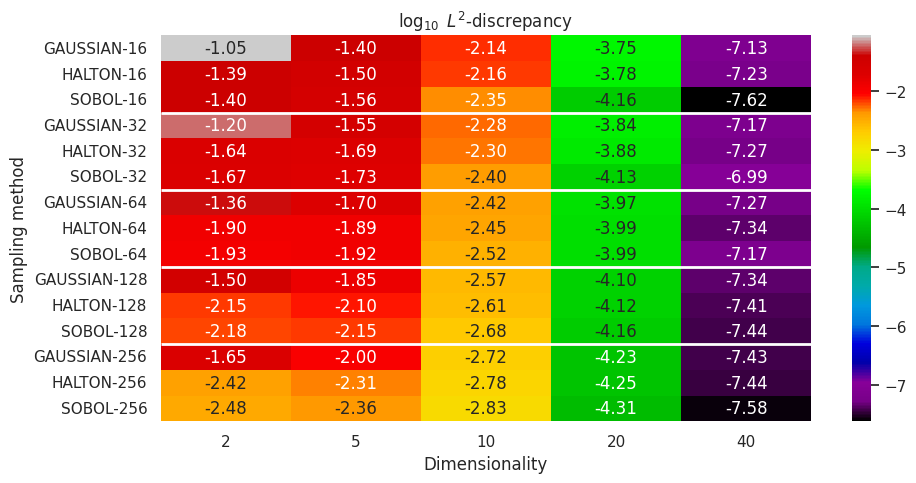

In [112]:
f, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(np.log10(view.sort_values("cache_size")[[2, 5, 10, 20, 40]]), annot=True, fmt=".2f", cmap="nipy_spectral")

ax.set_ylabel("Sampling method")
ax.set_xlabel("Dimensionality")
ax.set_title(r"$\log_{10}\ L^{2}$-discrepancy")
ax.hlines([3, 6, 9, 12], *ax.get_xlim(), color="white", linewidth=2)
plt.tight_layout()
plt.savefig("../data/figures/discrepancy.pdf")

In [115]:
import sqlite3

con = sqlite3.connect(f"../data/eaf/eaf.db", timeout=20)

view = pd.read_sql(
    '''
    SELECT run_id, fid, dim, sampler, cache_size, budget, eaf
    FROM eaf
    WHERE orthogonal = false AND mirrored = false 
    ''', con)

view 

,run_id,fid,dim,sampler,cache_size,budget,eaf
0,1,7,20,SOBOL,64,2,0.0
1,2,7,20,SOBOL,64,2,0.0
2,3,7,20,SOBOL,64,2,0.0
3,4,7,20,SOBOL,64,2,0.0
4,5,7,20,SOBOL,64,2,0.0
...,...,...,...,...,...,...,...
7732795,96,1,2,HALTON,256,25118,1.0
7732796,97,1,2,HALTON,256,25118,1.0
7732797,98,1,2,HALTON,256,25118,1.0
7732798,99,1,2,HALTON,256,25118,1.0


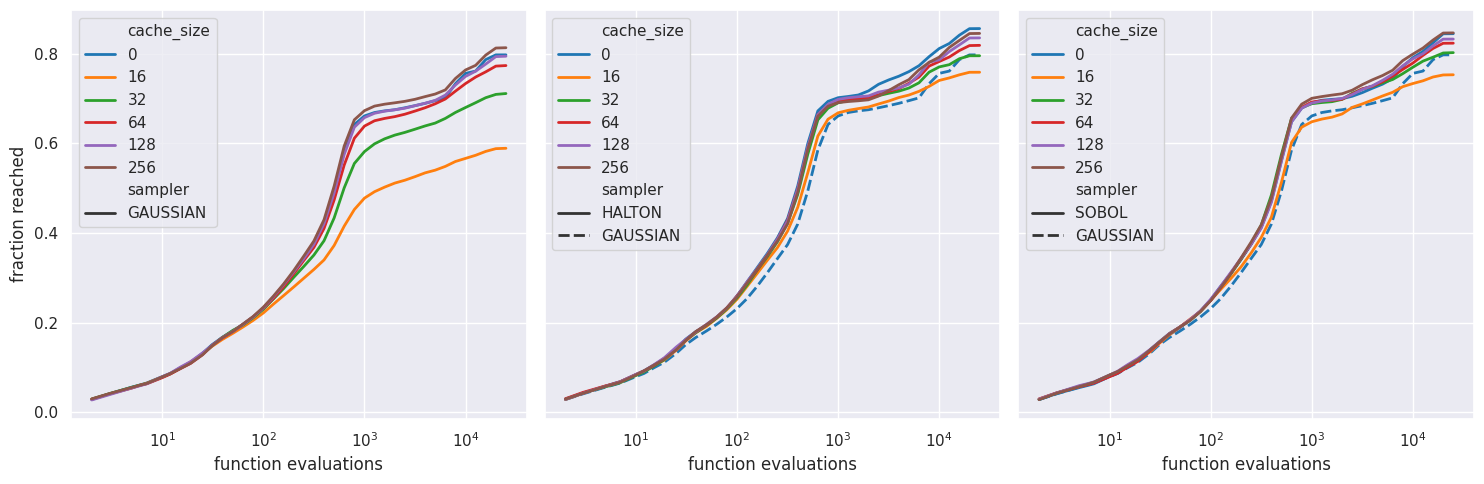

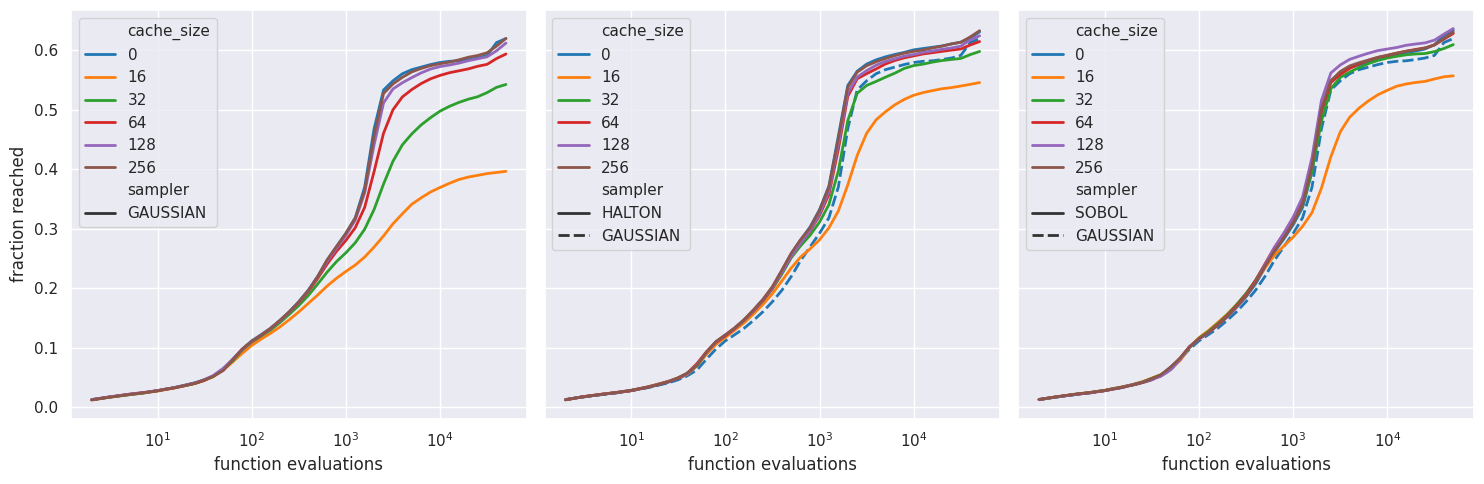

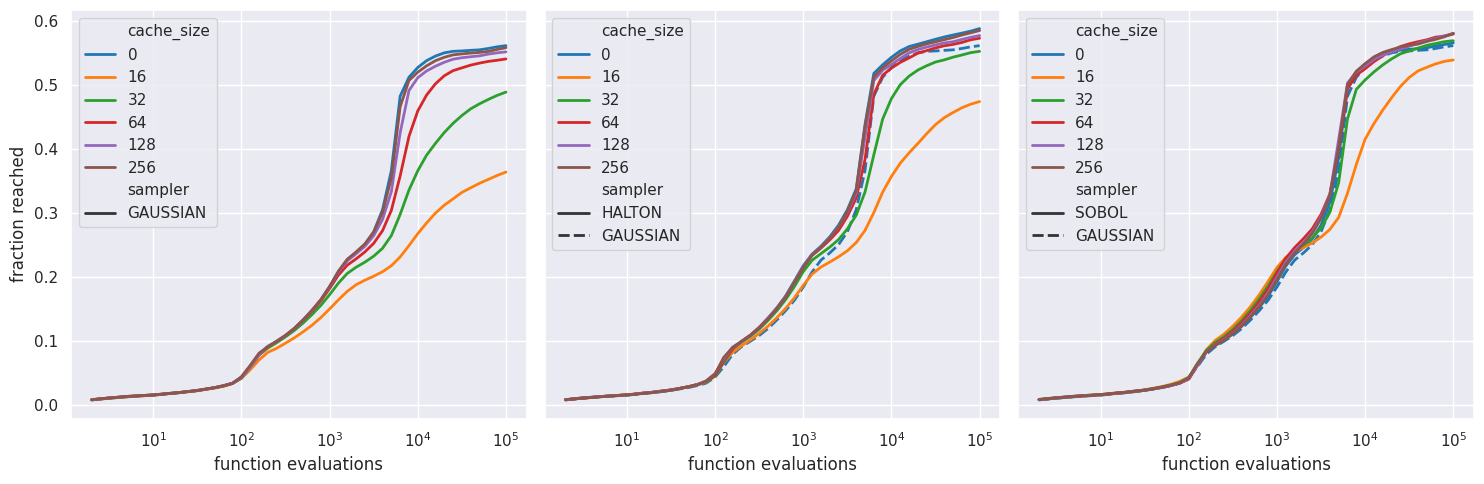

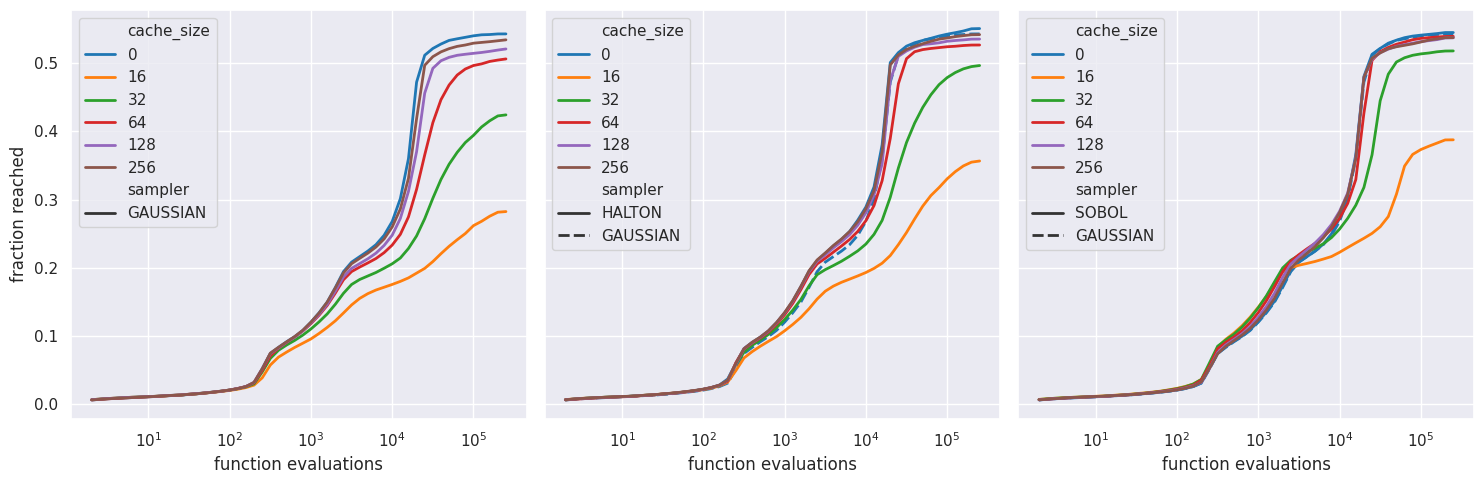

In [131]:

for dim in (2, 5, 10, 20):
    f, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
    default_cma = view.query(f"sampler == 'GAUSSIAN' and dim == {dim} and cache_size == 0")
    for sampler, ax in zip(("GAUSSIAN", "HALTON", "SOBOL", ), axes.ravel()):
        pdata = pd.concat(
            [view.query(f"sampler == '{sampler}' and dim == {dim}").sort_values(["cache_size"]), default_cma]
        )
        sns.lineplot(
            pdata,
            x="budget",
            y="eaf",
            hue="cache_size",
            style="sampler",
            errorbar=None,
            palette='tab10',
            lw=2,
            ax=ax
        )
        ax.set_xscale("log")
        # ax.set_title(sampler)
        ax.set_xlabel("function evaluations")
        ax.set_ylabel("fraction reached")
    # f.suptitle(f"Dimensionality {dim}")
    plt.tight_layout()
    plt.savefig(f"../data/figures/eaf_d{dim}.pdf")

UndefinedVariableError: name 'sampler' is not defined

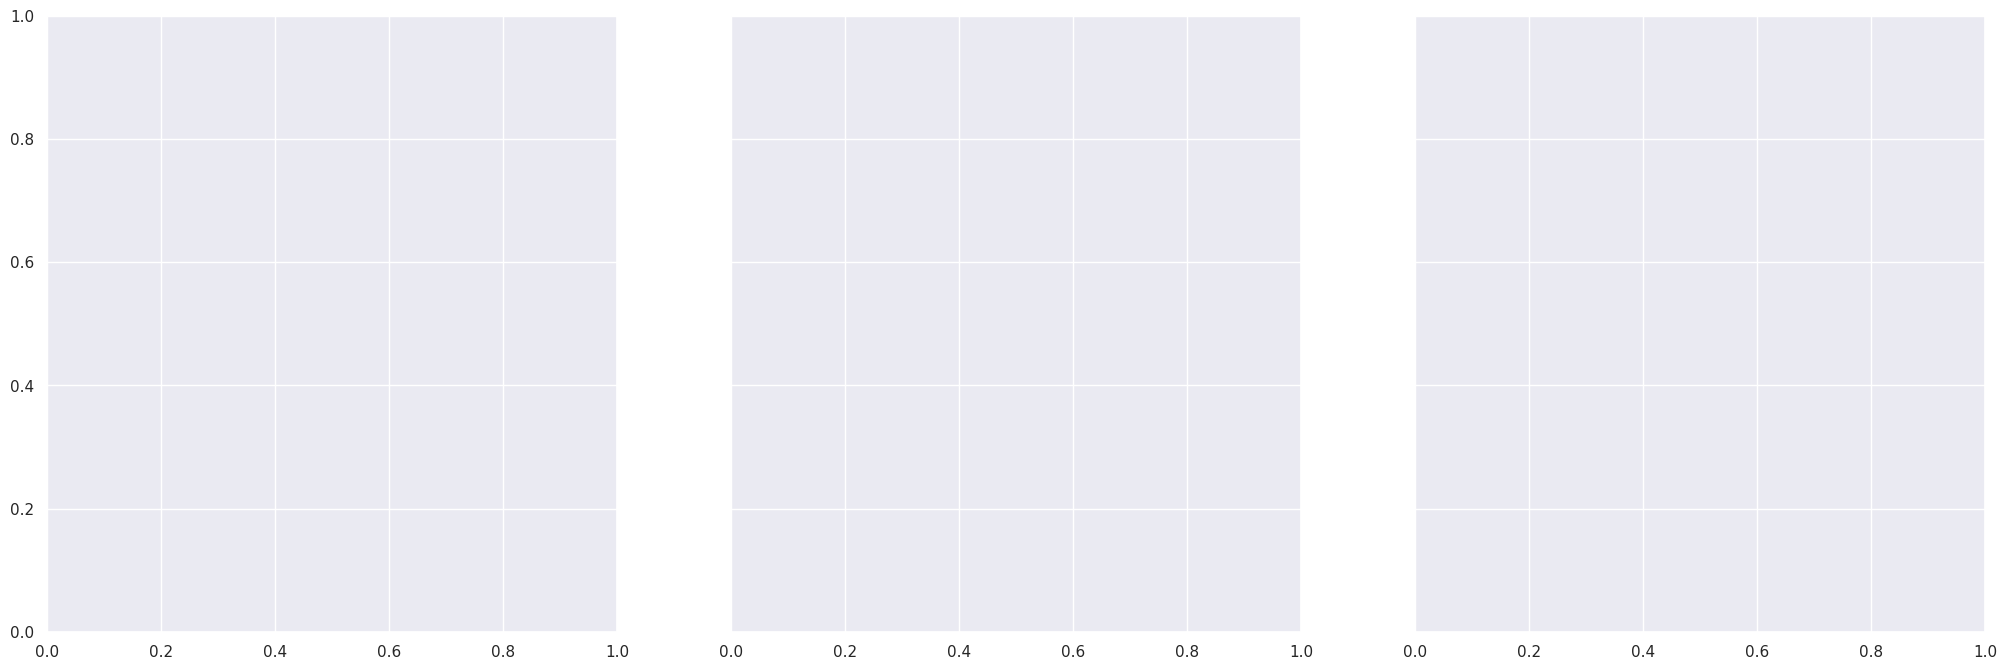

In [114]:
for fid in range(1, 25):
    f, axes = plt.subplots(1, 3, figsize=(25, 8), sharey=True)
    default_cma = view.query(f"sampler == 'GAUSSIAN' and fid == {fid} and cache_size == 0 and dim == 10")
    for sampler, ax in zip(("GAUSSIAN", "HALTON", "SOBOL", ), axes.ravel()):
        sns.lineplot(
            pd.concat(
                [view.query(f"sampler == '{sampler}' and fid == {fid} and dim == 10").sort_values(["cache_size"]), default_cma]
            ),
            x="budget",
            y="eaf",
            hue="cache_size",
            style="sampler",
            errorbar=None,
            palette='tab10',
            lw=2,
            ax=ax
        )
        ax.set_xscale("log")
        ax.set_title(sampler)
    f.suptitle(f"fid: {fid}")